# QC filtering

This notebook is about filtering scATAC seq data within an adata object to archive a good quality peak matrix.
For this task various QC filters are implemented. The latter includes filters related to:

- doublet score
- number of features per barcode
- mean insert size
- promotor enrichment


## Settings

In [1]:
#Path related settings (these should be the same as for the previous notebook)
output_dir = '/mnt/workspace/jdetlef/processed_data'
test = 'Esophagus'

## QC Settings

In [2]:
# Set the column in adata.obs containing the biological condition to evaluate
condition_column = "sample"

filter_xy = True  # True or False; filtering out chrX and chrY
binarize_mtx = True  # True or False; convert matrix to binary
select_hvf = True  # True or False; select only highly variable features

# Highly Variable Features thresholds:
min_limit = 1000
max_limit = 5000

############################# filters ##########################################

# Decide whether to estimate thresholds individual per condition (False) or globally (True)
global_threshold = True

# Filter to use:
n_features_filter = True # True or False; filtering out cells with numbers of features not in the range defined below
mean_insertsize_filter = True # True or False; filtering out cells with mean insertsize not in the range defined below
filter_pct_fp=True # True or False; filtering out cells with promotor_enrichment not in the range defined below
filter_n_fragments=True # True or False; filtering out cells with promotor_enrichment not in the range defined below
filter_chrM_fragments=True # True or False; filtering out cells with promotor_enrichment not in the range defined below
filter_uniquely_mapped_fragments=True # True or False; filtering out cells with promotor_enrichment not in the range defined


# if this is True thresholds below are ignored 
only_automatic_thresholds = True # True or False; to use automatic thresholds

############################# set default values #######################################
# 
# This will be applied to all samples the thresholds can be changed manually when plotted 
# if thresholds None they are set automatically

# default values n_features 
min_features = 5
max_features = 10000

# default mean_insertsize
upper_threshold_mis=160 
lower_threshold_mis=80

# default promotor enrichment
upper_threshold_pct_fp=0.4
lower_threshold_pct_fp=0.1

# default number of fragments
upper_thr_fragments=200000
lower_thr_fragments=0

# default number of fragments in chrM
upper_thr_chrM_fragments=10000
lower_thr_chrM_fragments=0

# default number of uniquely mapped fragments
upper_thr_um=20000
lower_thr_um=0



## Sum up settings

In [3]:
manual_thresholds = {}
if n_features_filter:
    manual_thresholds['n_features_by_counts'] = {'min' : min_features, 'max' : max_features}

if mean_insertsize_filter:
    manual_thresholds['mean_insertsize'] = {'min' : lower_threshold_mis, 'max' : upper_threshold_mis}

if filter_pct_fp:
    manual_thresholds['pct_fragments_in_promoters'] = {'min' : lower_threshold_pct_fp, 'max' : upper_threshold_pct_fp}

if filter_n_fragments:
    manual_thresholds['TN'] = {'min' : lower_thr_fragments, 'max' : upper_thr_fragments}

if filter_chrM_fragments:
    manual_thresholds['CM'] = {'min' : lower_thr_chrM_fragments, 'max' : upper_thr_chrM_fragments}

if filter_uniquely_mapped_fragments:
    manual_thresholds['UM'] = {'min' : lower_thr_um, 'max' : upper_thr_um}

obs_columns = list(manual_thresholds.keys())

## Loading packages and setup

In [4]:
# sctoolbox modules
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.annotation as an
from sctoolbox.qc_filter import *
from sctoolbox.plotting import *
from sctoolbox.atac_utils import *
import sctoolbox.atac as atac
# import episcanpy
import scanpy as sc
import episcanpy as epi
import numpy as np

## Setup path handling object 

In [5]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Load anndata 

In [6]:
# probably updated in future
assembling_output = tree.assembled_anndata
adata = epi.read_h5ad(assembling_output)
adata

AnnData object with n_obs × n_vars = 73652 × 150138
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'

In [7]:
adata.var 

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
0,411,0.005825,0.005808,99.44197,429.0,6.063785
1,0,0.000000,0.000000,100.00000,0.0,0.000000
2,22,0.000299,0.000299,99.97013,22.0,3.135494
3,0,0.000000,0.000000,100.00000,0.0,0.000000
4,0,0.000000,0.000000,100.00000,0.0,0.000000
...,...,...,...,...,...,...
150133,0,0.000000,0.000000,100.00000,0.0,0.000000
150134,0,0.000000,0.000000,100.00000,0.0,0.000000
150135,0,0.000000,0.000000,100.00000,0.0,0.000000
150136,0,0.000000,0.000000,100.00000,0.0,0.000000


<AxesSubplot:xlabel='Insertsize (bp)', ylabel='Count'>

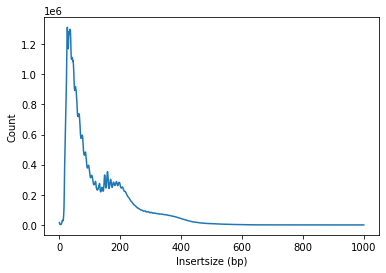

In [8]:
atac.plot_insertsize(adata)

# QC

## 1. filtering out chrX, chrY and chrM

In [9]:
non_m = [name for name in adata.var_names if not name.startswith('chrM')]  # remove chrM
adata = adata[:, non_m]

In [10]:
if filter_xy:
    non_xy = [name for name in adata.var_names if not name.startswith('chrY') | name.startswith('chrX')]
    adata = adata[:, non_xy]

In [11]:
display(adata)

View of AnnData object with n_obs × n_vars = 73652 × 150138
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'

## 2. removing empty cells and features

In [12]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)
# log-convert number of features
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
display(adata)

AnnData object with n_obs × n_vars = 71726 × 148047
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'

## 3. binarize

In [13]:
adata.raw = adata
if binarize_mtx:
    epi.pp.binarize(adata)
    adata.layers['binary'] = adata.X.copy()

## 5. visualize adata

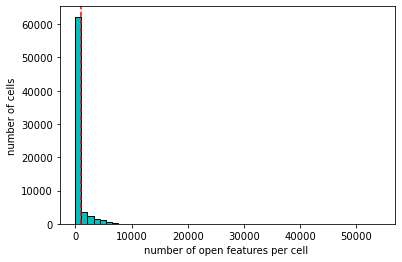

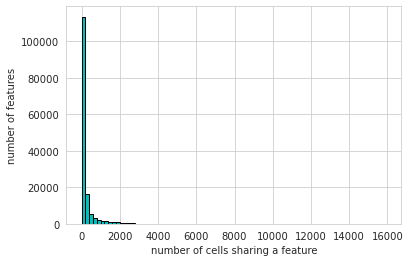

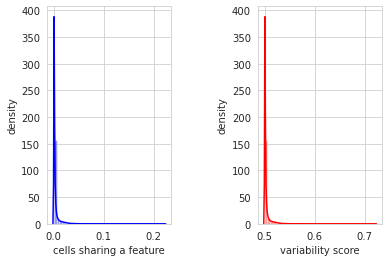

In [14]:
plot_ov_hist(adata, threshold_features=1000) # FIXME: Later plots do not visualize

## 6. filter cells

### 6.1 get thresholds dict

In [15]:
groupby = condition_column if global_threshold is False else None
default_thresholds = build_default_thresholds(adata, manual_thresholds, groupby)
default_thresholds

{'n_features_by_counts': {'min': 5, 'max': 10000},
 'mean_insertsize': {'min': 80, 'max': 160},
 'pct_fragments_in_promoters': {'min': 0.1, 'max': 0.4},
 'TN': {'min': 0, 'max': 200000},
 'CM': {'min': 0, 'max': 10000},
 'UM': {'min': 0, 'max': 20000}}

In [16]:
manual_thresholds

{'n_features_by_counts': {'min': 5, 'max': 10000},
 'mean_insertsize': {'min': 80, 'max': 160},
 'pct_fragments_in_promoters': {'min': 0.1, 'max': 0.4},
 'TN': {'min': 0, 'max': 200000},
 'CM': {'min': 0, 'max': 10000},
 'UM': {'min': 0, 'max': 20000}}

In [17]:
thresholds = get_thresholds_atac_wrapper(adata, default_thresholds, only_automatic_thresholds, groupby=None)
thresholds_as_table(thresholds)

,Parameter,Minimum,Maximum
0,n_features_by_counts,-5.290193,17.815598
1,mean_insertsize,67.341011,196.880907
2,pct_fragments_in_promoters,-0.433592,0.848741
3,TN,-14.714212,61.757823
4,CM,-1.456780,2.157723
5,UM,-11.174259,42.551504


### 6.2 plot thresholds

In [24]:
%matplotlib widget
%bgcolor PowderBlue

#Plot violins and sliders
obs_figure, obs_slider_dict = quality_violin(adata, columns=obs_columns,
                                            groupby=condition_column,
                                            which="obs",
                                            thresholds=thresholds,
                                            global_threshold=global_threshold,
                                            title="Cell quality control (before)",
                                            save=tree.qc_plots + "cell_filtering.png")
obs_figure

In [19]:
# Get final thresholds
final_thresholds = get_slider_thresholds(obs_slider_dict)
thresholds_as_table(final_thresholds) # show thresholds

,Parameter,Minimum,Maximum
0,n_features_by_counts,1.000000,17.815598
1,mean_insertsize,67.341011,196.880907
2,pct_fragments_in_promoters,0.000000,0.848741
3,TN,1.000000,61.757823
4,CM,0.000000,2.157723
5,UM,1.000000,42.551504


### 6.3 filter adata

In [20]:
apply_qc_thresholds(adata, final_thresholds)

Filtering based on 'n_features_by_counts' from 71726 -> 56540 cells
Filtering based on 'mean_insertsize' from 56540 -> 48634 cells
Filtering based on 'pct_fragments_in_promoters' from 48634 -> 47994 cells
Filtering based on 'TN' from 47994 -> 46652 cells
Filtering based on 'CM' from 46652 -> 45823 cells
Filtering based on 'UM' from 45823 -> 45493 cells


## 7. save plots

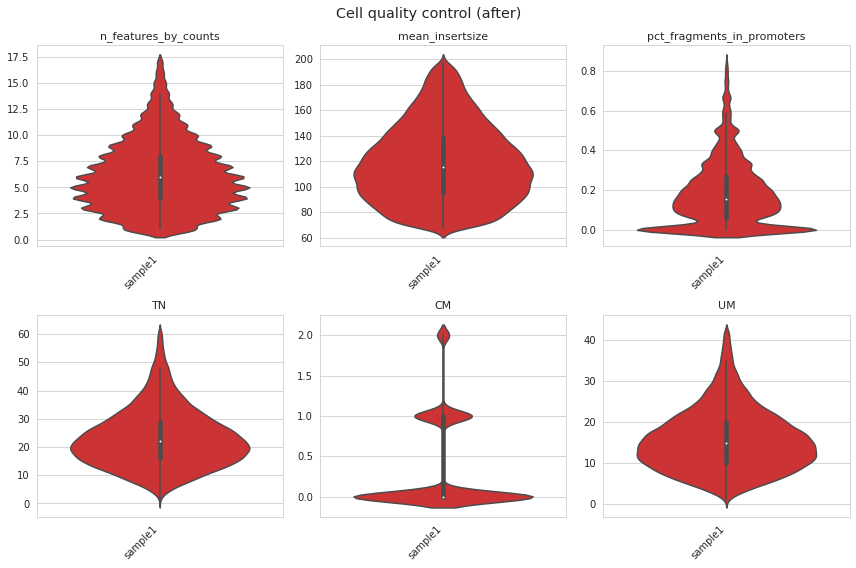

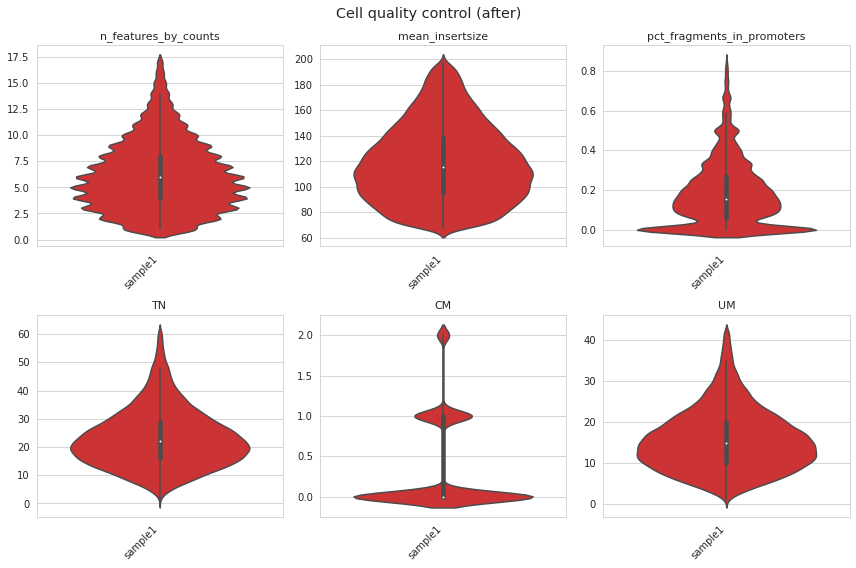

In [22]:
%matplotlib inline 

#Plot violins and sliders
figure, slider_dict = quality_violin(adata, columns=obs_columns,
                                     groupby=condition_column,
                                     which="obs", ncols=3,
                                     global_threshold = global_threshold,
                                     title="Cell quality control (after)",
                                     save=tree.qc_plots + "cell_filtering_final.png")
figure 

## 8. save adata

In [23]:
adata_output = tree.qc_anndata
adata.write(filename=adata_output)